# Calling Packages

In [ ]:
!pip install google-play-scraper nltk gensim pyLDAvis torch transformers -U huggingface-hub -U

In [ ]:
import pandas as pd
import numpy as np
import nltk

from google_play_scraper import Sort, reviews

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from transformers import pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Scraping Shopee Reviews

In [ ]:
result, continuation_token = reviews(
    'com.shopee.id',
    lang='id',
    country='id',
    sort=Sort.NEWEST,  # Ulasan paling relevan
    count=3000  # Ambil 3000 ulasan
)

NameError: name 'reviews' is not defined

In [ ]:
df_reviews = pd.DataFrame(np.array(result), columns=['review'])

df_reviews = df_reviews.join(pd.DataFrame(df_reviews.pop('review').tolist()))

df_reviews.head()

# Preprocessing

In [ ]:
df_reviews.dropna(subset=['content'], inplace=True)

# Membersihkan teks
def clean_text(text):
    text = text.lower()  # Konversi ke huruf kecil
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter selain huruf
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

df_reviews['clean_content'] = df_reviews['content'].apply(clean_text)

# Stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Tokenisasi, stopword removal, dan lemmatization
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return words

df_reviews['processed_content'] = df_reviews['clean_content'].apply(preprocess_text)

print(df_reviews[['content', 'processed_content']].head())

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                             content  \
0                                        Sangat puas   
1                                           Keren...   
2                               Mantap membantu kami   
3  oke sih...tapi kenapa kalo 1/2 barang yg gak k...   
4                                       Terima kasih   

                                   processed_content  
0                                             [puas]  
1                                            [keren]  
2                                 [mantap, membantu]  
3  [oke, sihtapi, kalo, barang, yg, gak, ambil, s...  
4                                    [terima, kasih]  


In [ ]:
# Membuat dictionary dari teks yang telah diproses
dictionary = corpora.Dictionary(df_reviews['processed_content'])

dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=10000)

# Konversi teks ke format bag-of-words
corpus = [dictionary.doc2bow(text) for text in df_reviews['processed_content']]

print(f"Jumlah kata unik dalam dictionary: {len(dictionary)}")
print(f"Contoh representasi BOW: {corpus[:1]}")

Jumlah kata unik dalam dictionary: 270
Contoh representasi BOW: [[(0, 1)]]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Jumlah topik: 2, Coherence Score: 0.46567718334086033
Jumlah topik: 3, Coherence Score: 0.3882239787282434
Jumlah topik: 4, Coherence Score: 0.4429382649113932
Jumlah topik: 5, Coherence Score: 0.4015961041350929
Jumlah topik: 6, Coherence Score: 0.4270621824383045
Jumlah topik: 7, Coherence Score: 0.39005401324527644
Jumlah topik: 8, Coherence Score: 0.39795070807356175
Jumlah topik: 9, Coherence Score: 0.41890388186119476


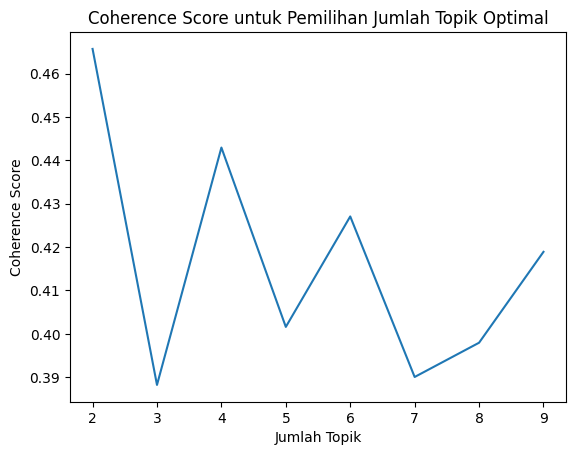

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15, workers=4, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Menentukan range jumlah topik
start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence_values(dictionary, corpus, df_reviews['processed_content'], limit, start, step)

# Coherence score tiap jumlah topik
for num, coherence in zip(range(start, limit, step), coherence_values):
    print(f"Jumlah topik: {num}, Coherence Score: {coherence}")

# Visualisasi coherence score

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score")
plt.title("Coherence Score untuk Pemilihan Jumlah Topik Optimal")
plt.show()

In [ ]:
# Jumlah topik optimal
optimal_topics = 2

# Train LDA jumlah topik optimal
lda_optimal = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_topics, passes=20, workers=4, random_state=42)

# Menampilkan topik
topics = lda_optimal.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Topik {idx}: {topic}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topik 0: 0.086*"shopee" + 0.044*"mantap" + 0.034*"aplikasi" + 0.027*"gak" + 0.022*"ok" + 0.021*"belanja" + 0.021*"nya" + 0.016*"good" + 0.015*"ongkir" + 0.015*"mudah"
Topik 1: 0.074*"bagus" + 0.041*"shopee" + 0.038*"membantu" + 0.037*"yg" + 0.034*"nya" + 0.032*"belanja" + 0.028*"barang" + 0.023*"banget" + 0.020*"aplikasi" + 0.018*"puas"


In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_optimal, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for row in lda_model[corpus]:
        if row:  # Pastikan ada nilai dalam row
            sorted_topic = max(row, key=lambda x: x[1])  # Menggunakan max untuk keterbacaan
            dominant_topics.append(sorted_topic[0])
        else:
            dominant_topics.append(None)  # Handle jika tidak ada topik
    return dominant_topics

# Menentukan topik dominan untuk setiap ulasan
df_reviews['dominant_topic'] = get_dominant_topic(lda_optimal, corpus)

# Mapping nama topik berdasarkan indeks topik LDA
topic_labels = {
    0: "Kepuasan Pengguna dan Fitur Aplikasi",
    1: "Pengiriman dan Proses Belanja"
}

# Gunakan .map untuk mengubah angka menjadi label topik
df_reviews['topic_label'] = df_reviews['dominant_topic'].map(topic_labels)

# Menampilkan hasil beberapa baris pertama
print(df_reviews[['content', 'dominant_topic', 'topic_label']].head())

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                             content  dominant_topic  \
0                                        Sangat puas               1   
1                                           Keren...               1   
2                               Mantap membantu kami               0   
3  oke sih...tapi kenapa kalo 1/2 barang yg gak k...               0   
4                                       Terima kasih               1   

                            topic_label  
0         Pengiriman dan Proses Belanja  
1         Pengiriman dan Proses Belanja  
2  Kepuasan Pengguna dan Fitur Aplikasi  
3  Kepuasan Pengguna dan Fitur Aplikasi  
4         Pengiriman dan Proses Belanja  


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


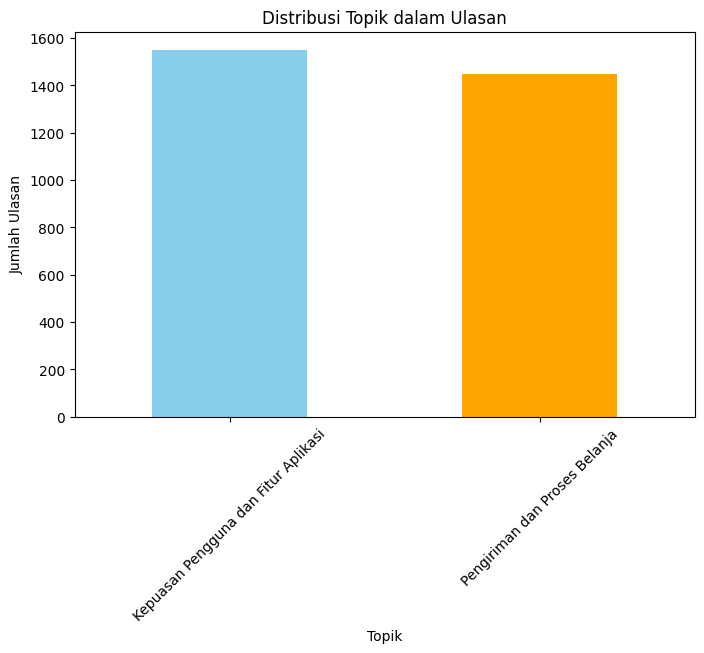

In [ ]:
# Visualisasi distribusi topik
topic_counts = df_reviews['topic_label'].value_counts()

plt.figure(figsize=(8, 5))
topic_counts.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribusi Topik dalam Ulasan')
plt.xlabel('Topik')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=45)
plt.show()

In [ ]:
def classify_new_review(new_text, dictionary, lda_model):
    processed_text = preprocess_text(clean_text(new_text))
    bow_vector = dictionary.doc2bow(processed_text)
    topic_probabilities = lda_model.get_document_topics(bow_vector)
    dominant_topic = sorted(topic_probabilities, key=lambda x: x[1], reverse=True)[0][0]
    return topic_labels[dominant_topic]

# Contoh pengujian pada ulasan baru
new_review = "pengiriman tidak efisien!"
predicted_topic = classify_new_review(new_review, dictionary, lda_optimal)
print("Topik yang diprediksi:", predicted_topic)

Topik yang diprediksi: Pengiriman dan Proses Belanja


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Analisis Sentimen

## IndoBERT (Deep Learning)

IndoBERT digunakan sekaligus untuk melabelkan sentimen positif, netral, dan negatif dari ulasan aplikasi Shopee

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


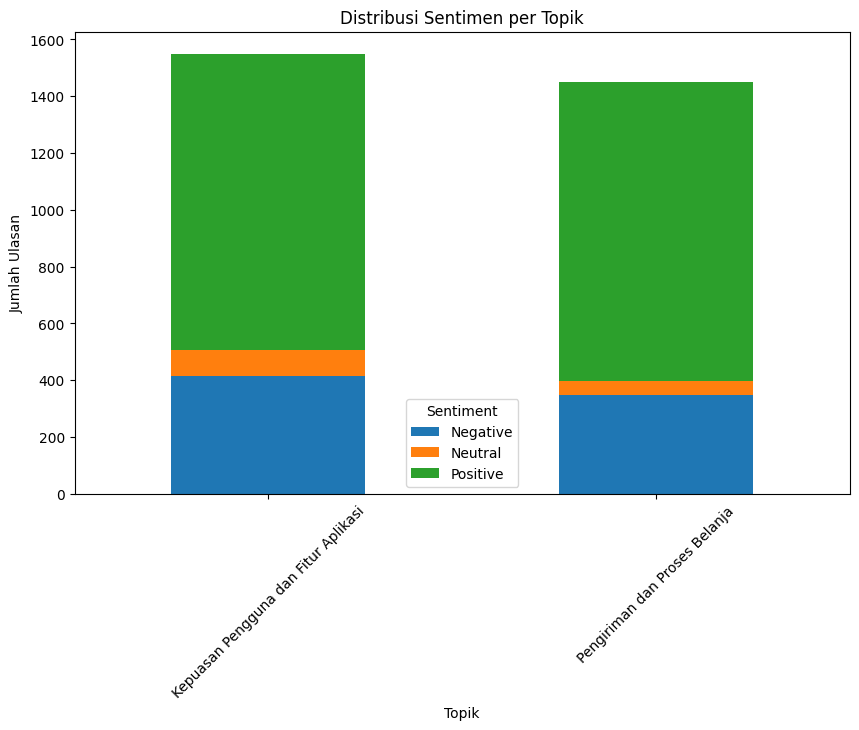

In [ ]:
# Load model IndoBERT
sentiment_pipeline = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

def analyze_sentiment_bert(text):
    result = sentiment_pipeline(text)
    label = result[0]['label']

    # Konversi label model ke kategori yang sesuai
    if label == 'positive':
        return 'Positive'
    elif label == 'negative':
        return 'Negative'
    else:
        return 'Neutral'

# Memprediksi sentimen
df_reviews['sentiment'] = df_reviews['content'].apply(analyze_sentiment_bert)

# Distribusi sentimen per topik
sentiment_distribution = df_reviews.groupby(['topic_label', 'sentiment']).size().unstack()

# Visualisasi
sentiment_distribution.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Distribusi Sentimen per Topik')
plt.xlabel('Topik')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

In [ ]:
# Contoh prediksi
new_review = "anjirrr, keren bgttt suka lancar ga ngelag!!"
predicted_sentiment = sentiment_pipeline(new_review)

print(f"Ulasan: {new_review}")
print(f"Sentimen yang diprediksi: {predicted_sentiment[0]['label']}")

Ulasan: anjirrr, keren bgttt suka lancar ga ngelag!!
Sentimen yang diprediksi: positive


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train Test Split

In [ ]:
# Menentukan fitur (X) dan label (y)
X = df_reviews['clean_content']
y = df_reviews['sentiment']

# Membagi data menjadi train dan test set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## SVM

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy Score (SVM): 0.8733333333333333
Classification Report (SVM):
               precision    recall  f1-score   support

    Negative       0.80      0.75      0.77       148
     Neutral       0.00      0.00      0.00        22
    Positive       0.90      0.96      0.93       430

    accuracy                           0.87       600
   macro avg       0.56      0.57      0.57       600
weighted avg       0.84      0.87      0.86       600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


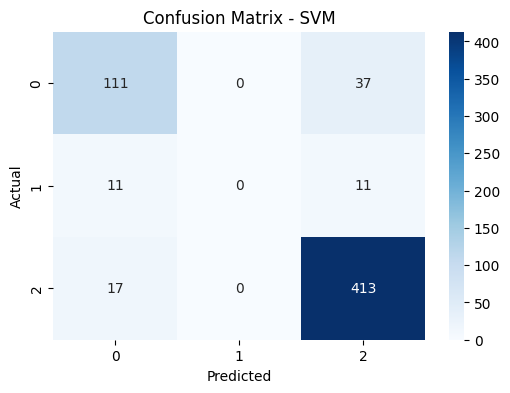

In [ ]:
# Pipeline untuk TF-IDF + SVM
vectorizer_svm = TfidfVectorizer()
X_train_svm = vectorizer_svm.fit_transform(X_train)
X_test_svm = vectorizer_svm.transform(X_test)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_svm, y_train)

# Prediksi Sentimen
y_pred_svm = svm_model.predict(X_test_svm)

# Evaluasi Model
print("Accuracy Score (SVM):", accuracy_score(y_test, y_pred_svm))
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
def predict_sentiment_svm(text):
    # Preprocessing text
    text_clean = preprocess_text(text)

    # Jika preprocess_text menghasilkan list, ubah menjadi string
    if isinstance(text_clean, list):
        text_clean = " ".join(text_clean)

    # Transformasikan teks menggunakan vectorizer
    text_vectorized = vectorizer_svm.transform([text_clean])

    # Prediksi menggunakan model SVM
    return svm_model.predict(text_vectorized)[0]

# Contoh Prediksi
new_review = "ahh apaan, aplikasi lemot!"
print("Sentimen prediksi (SVM):", predict_sentiment_svm(new_review))

Sentimen prediksi (SVM): Negative


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Multinomial NB

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/

Accuracy Score (Naive Bayes): 0.8716666666666667
Classification Report (Naive Bayes):
               precision    recall  f1-score   support

    Negative       0.80      0.74      0.76       148
     Neutral       0.00      0.00      0.00        22
    Positive       0.89      0.96      0.93       430

    accuracy                           0.87       600
   macro avg       0.56      0.57      0.56       600
weighted avg       0.84      0.87      0.85       600



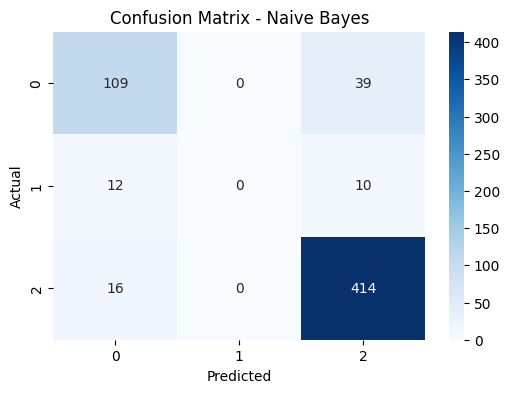

In [ ]:
# Pipeline untuk TF-IDF + Multinomial Naive Bayes
vectorizer_nb = CountVectorizer()
X_train_nb = vectorizer_nb.fit_transform(X_train)
X_test_nb = vectorizer_nb.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_nb, y_train)

# Prediksi
y_pred_nb = nb_model.predict(X_test_nb)

# Evaluasi Model
print("Accuracy Score (Naive Bayes):", accuracy_score(y_test, y_pred_nb))
print("Classification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def predict_sentiment_nb(text):
    # Preprocessing text
    text_clean = preprocess_text(text)

    # Jika hasil preprocessing berupa list, ubah menjadi string
    if isinstance(text_clean, list):
        text_clean = " ".join(text_clean)

    # Transformasikan teks menggunakan vectorizer
    text_vectorized = vectorizer_nb.transform([text_clean])

    # Prediksi menggunakan model Naive Bayes
    return nb_model.predict(text_vectorized)[0]

# Contoh Prediksi
new_review = "ahh apaan, aplikasi lemot!"
print("Sentimen prediksi (Naive Bayes):", predict_sentiment_nb(new_review))

Sentimen prediksi (Naive Bayes): Negative


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ML Model Comparation

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Comparison of Model Performance:
Naive Bayes Accuracy: 0.8716666666666667
SVM Accuracy: 0.8733333333333333


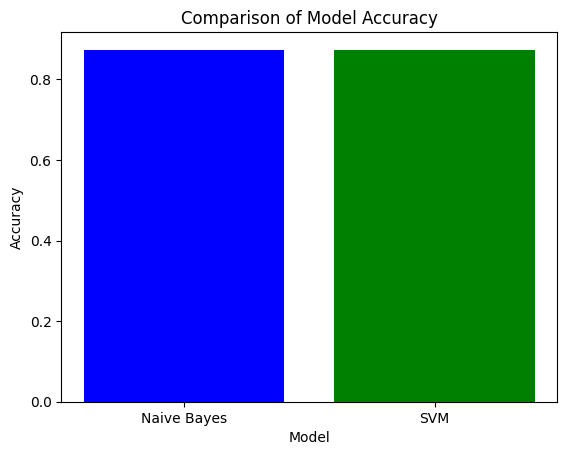

In [ ]:
print("Comparison of Model Performance:")
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

models = ['Naive Bayes', 'SVM']
accuracies = [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_svm)]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.show()

### Menyimpan Model

In [ ]:
import joblib

# Simpan Model Naive Bayes
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(vectorizer_nb, 'vectorizer_nb.pkl')

# Simpan Model SVM
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(vectorizer_svm, 'vectorizer_svm.pkl')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Models have been saved successfully!
